# 2018-12-06 - A simple STDP-based ring for finer response tuning
Pour tester la STDP, on fait un toy model qui ressemble au ring de david, avec une entrée von mises, un ring exc et un ring inh.

# Comment faire de la STDP inhibitrice ?
je suis trop con c'est pas des poids négatifs c'est des poids positifs inhibiteur, donc ça marche
ah bah non c'est des poids négatifs, c'est pynn qui est con, pas moi

# 06 au soir
TODO : voir si ça marche déjà comme ça, pour montrer les spikes, puis rajouter du poisson dedans

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def VanillaRasterPlot(SpikesP, SpikesE, SpikesI, title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
            
        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = figsize)
        plot_spiketrains(axs[0], SpikesP, color = 'k', ylabel = 'Neuron Index', do_ticks = False)
        axs[0].set_title('Poisson input')
        plot_spiketrains(axs[1], SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs[1].set_title('Inhibitory population')
        plot_spiketrains(axs[2], SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs[2].set_title('Excitatory population')
        plt.xlabel('Time(ms)')
        fig.suptitle(title, fontsize=12)
        return fig, axs

In [3]:
# Hyperparameters
n_pop = 60
neuron_parameters = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -65.5, #mV - McCormick
                 'v_thresh': -52.5, #mV - McCormick
                    }

simtime = 1000
rng = sim.NumpyRNG(seed = 42)

rate_gain = 10. #multiplier for the rates
angle_input = 90 #degrees
b_theta = 30 #degrees

normal_weights = rnd('normal_clipped', mu=.5,sigma=.2, low = 0.1, 
                   high = 5,
                   rng = rng)
delays = rnd('normal_clipped', mu=1,sigma=.1, low = 0.1, 
                   high = 5,
                   rng = rng)
sparseness = .1

In [4]:
sim.setup(timestep = .1, threads = 4)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                    initial_values={"v": neuron_parameters["v_reset"]},
                    label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop, 
                           sim.SpikeSourcePoisson(rate=500, duration=simtime, start = 0),
                    label="Entree Orientation")

In [5]:
STDP_syn= sim.STDPMechanism(
                    timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                        A_plus=0.9, A_minus=0.9),
                    weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=1),
                    weight=1,
                    delay=delays,
                    dendritic_delay_fraction=1.)

#Intras
syn_exc_exc = sim.Projection(exc, exc,
                            connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                            synapse_type=STDP_syn,
                            receptor_type='excitatory')
syn_inh_inh = sim.Projection(inh, inh,
                            connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                            synapse_type=sim.StaticSynapse(weight = .6, delay = 1),
                            receptor_type='inhibitory') #we can't have two types of synapses now can we ?

#Inters
syn_exc_inh = sim.Projection(exc, inh,
                            connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                            synapse_type=STDP_syn,
                            receptor_type='excitatory')
syn_inh_ex = sim.Projection(inh, exc,
                            connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                            synapse_type=sim.StaticSynapse(weight = .6, delay = 1),
                            receptor_type='inhibitory')

#Input
syn_inp_exc = sim.Projection(input_pop, exc,
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight = .6, delay = 1) ,
                            receptor_type='excitatory')

In [6]:
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM
    
angle = 1. * np.arange(n_pop)
rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
rates /= rates.mean()
rates *= rate_gain
for i, cell in enumerate(input_pop):
    cell.set_parameters(rate=rates[i])

In [7]:
exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime)
sim.end()

In [8]:
exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

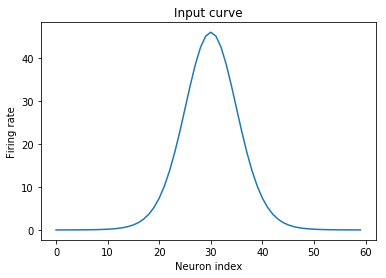

In [9]:
plt.plot(rates)
plt.xlabel('Neuron index')
plt.ylabel('Firing rate')
plt.title('Input curve')
plt.show()

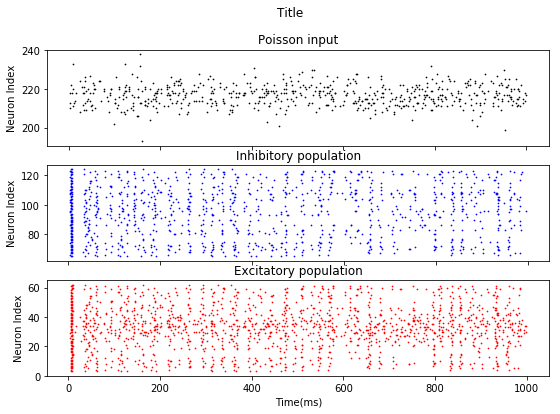

In [10]:
VanillaRasterPlot(inp_data, exc_data, inh_data)
plt.show()

In [11]:
spiketrain_list = []
spiketrain_len = []
for spiketrain in np.asarray(exc_data.spiketrains):
    spiketrain_list.append(np.array(spiketrain, dtype = float))
    spiketrain_len.append(len(np.array(spiketrain, dtype = float)))
    
spiketrain_array = np.asarray(spiketrain_list)
spikelen_array = np.asarray(spiketrain_len)

In [12]:
from lmfit.models import GaussianModel

x = np.linspace(0, 60,60)
y = np.asarray(spikelen_array)

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 60
    # variables        = 3
    chi-square         = 6745.77881
    reduced chi-square = 118.346997
    Akaike info crit   = 289.339660
    Bayesian info crit = 295.622694
[[Variables]]
    sigma:      17.6045188 +/- 1.57680905 (8.96%) (init = 17.79661)
    center:     30.9174228 +/- 1.33910589 (4.33%) (init = 33.10169)
    amplitude:  1711.43031 +/- 121.343517 (7.09%) (init = 3363.559)
    fwhm:       41.4554729 +/- 3.71310150 (8.96%) == '2.3548200*sigma'
    height:     38.7833346 +/- 2.52208653 (6.50%) == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.694



Text(0.5, 1.0, '$\\sigma$ :      17.6045188 ')

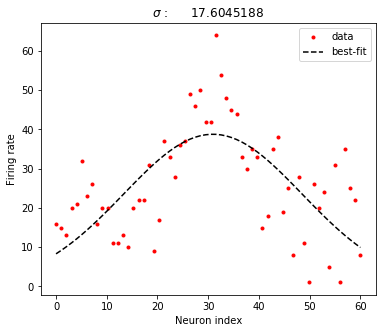

In [13]:
fig, ax = plt.subplots(figsize = (6,5))
out.plot_fit(ax = ax, datafmt = '.r', fitfmt = '--k')
plt.xlabel ('Neuron index')
plt.ylabel('Firing rate')
plt.title(r'$\sigma$ ' +out.fit_report(min_correl=.25).split('sigma')[1].split('+')[0])

Text(0.5, 1.0, '$\\sigma$ :      5.37462716 ')

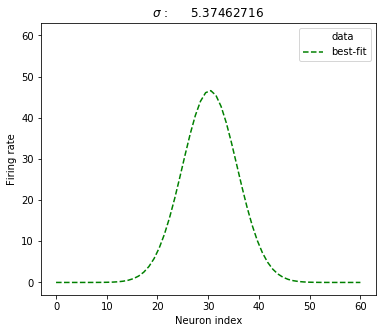

In [14]:
spiketrain_list = []
spiketrain_len = []
for spiketrain in np.asarray(inp_data.spiketrains):
    spiketrain_list.append(np.array(spiketrain, dtype = float))
    spiketrain_len.append(len(np.array(spiketrain, dtype = float)))
    
spiketrain_array = np.asarray(spiketrain_list)
spikelen_array = np.asarray(spiketrain_len)

from lmfit.models import GaussianModel

x = np.linspace(0, 60,60)
y = np.asarray(spikelen_array)

mod = GaussianModel()

pars = mod.guess(y, x=x)

out = mod.fit(y, pars, x=x)


fig, ax = plt.subplots(figsize = (6,5))
out.plot_fit(ax = ax, datafmt = '.g', fitfmt = '--g', data_kws={'alpha' : 0})

plt.xlabel ('Neuron index')
plt.ylabel('Firing rate')
plt.title(r'$\sigma$ ' +out.fit_report(min_correl=.25).split('sigma')[1].split('+')[0])